# Experiment 5: Persona Consistency Analysis

**Goal:** Test how different persona system prompts affect responses to the SAME queries.

**Setup:**
- Fixed test prompts
- Different persona system prompts (teacher, scientist, casual friend, etc.)
- Measure: vocabulary, formality, explanation depth

In [1]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [3]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda


## 1. Define Personas

In [4]:
PERSONAS = {
    "none": "",
    
    "teacher": """You are a patient, encouraging teacher. Explain concepts clearly 
using simple language. Use examples and check understanding.""",
    
    "scientist": """You are a rigorous scientist. Be precise and cite evidence.
Distinguish between facts and hypotheses. Quantify uncertainty.""",
    
    "friend": """You're a casual, friendly buddy. Keep it relaxed and fun.
Use informal language, slang is okay. Be supportive.""",
    
    "executive": """You are a busy executive. Be extremely concise and direct.
Focus on key points only. No fluff, just actionable information.""",
    
    "philosopher": """You are a thoughtful philosopher. Consider multiple perspectives.
Ask probing questions. Explore nuance and deeper meaning.""",
    
    "child": """Explain things as if talking to a curious 8-year-old.
Use very simple words and fun examples.""",
    
    "expert": """You are a domain expert with deep technical knowledge.
Use precise terminology. Assume the user has advanced understanding."""
}

## 2. Generate Responses

In [5]:
TEST_SUBSET = ALL_TEST_PROMPTS[:10]

results = []
for persona_name, persona_text in tqdm(PERSONAS.items()):
    for test in TEST_SUBSET:
        prompt = build_chat_prompt(persona_text, test["prompt"], model.tokenizer)
        output = model.generate_with_probs(prompt, max_new_tokens=100, temperature=0.7)
        
        # GenerationOutput is a dataclass
        results.append({
            "persona": persona_name,
            "test_id": test["id"],
            "category": test["category"],
            "response": output.text,
            "n_tokens": len(output.tokens)
        })

persona_df = pd.DataFrame(results)

  0%|          | 0/8 [00:00<?, ?it/s]

## 3. Extract Style Features

In [6]:
# Formality indicators
INFORMAL_WORDS = ["gonna", "wanna", "kinda", "yeah", "yep", "nope", "cool", "awesome", "hey", "ok", "okay"]
FORMAL_WORDS = ["therefore", "however", "furthermore", "consequently", "thus", "hence", "moreover"]
TECHNICAL_WORDS = ["hypothesis", "analysis", "data", "evidence", "methodology", "framework", "paradigm"]
SIMPLE_WORDS = ["like", "thing", "stuff", "lot", "very", "really", "big", "small", "good", "bad"]

def analyze_style(response):
    text = response.lower()
    words = text.split()
    
    return {
        "length": len(words),
        "avg_word_length": np.mean([len(w) for w in words]) if words else 0,
        "informal_count": sum(1 for w in INFORMAL_WORDS if w in text),
        "formal_count": sum(1 for w in FORMAL_WORDS if w in text),
        "technical_count": sum(1 for w in TECHNICAL_WORDS if w in text),
        "simple_count": sum(1 for w in SIMPLE_WORDS if w in text),
        "question_count": response.count("?"),
        "exclamation_count": response.count("!"),
        "sentence_count": len(re.split(r'[.!?]+', response)),
    }

# Apply to all responses
style_features = []
for _, row in persona_df.iterrows():
    feat = analyze_style(row["response"])
    feat["persona"] = row["persona"]
    style_features.append(feat)

style_df = pd.DataFrame(style_features)

## 4. Compare Personas

In [7]:
persona_summary = style_df.groupby('persona').mean().round(2)
print("=== Persona Style Summary ===")
print(persona_summary)

=== Persona Style Summary ===
             length  avg_word_length  informal_count  formal_count  \
persona                                                              
child          41.6             3.87             0.1           0.3   
executive      33.8             3.97             0.1           0.4   
expert         34.2             3.99             0.0           0.6   
friend         34.2             4.04             0.1           0.4   
none           25.7             4.12             0.1           0.3   
philosopher    33.0             3.98             0.1           0.3   
scientist      39.3             4.24             0.2           0.5   
teacher        31.3             4.08             0.1           0.4   

             technical_count  simple_count  question_count  exclamation_count  \
persona                                                                         
child                    0.0           0.0             0.0                0.0   
executive                0

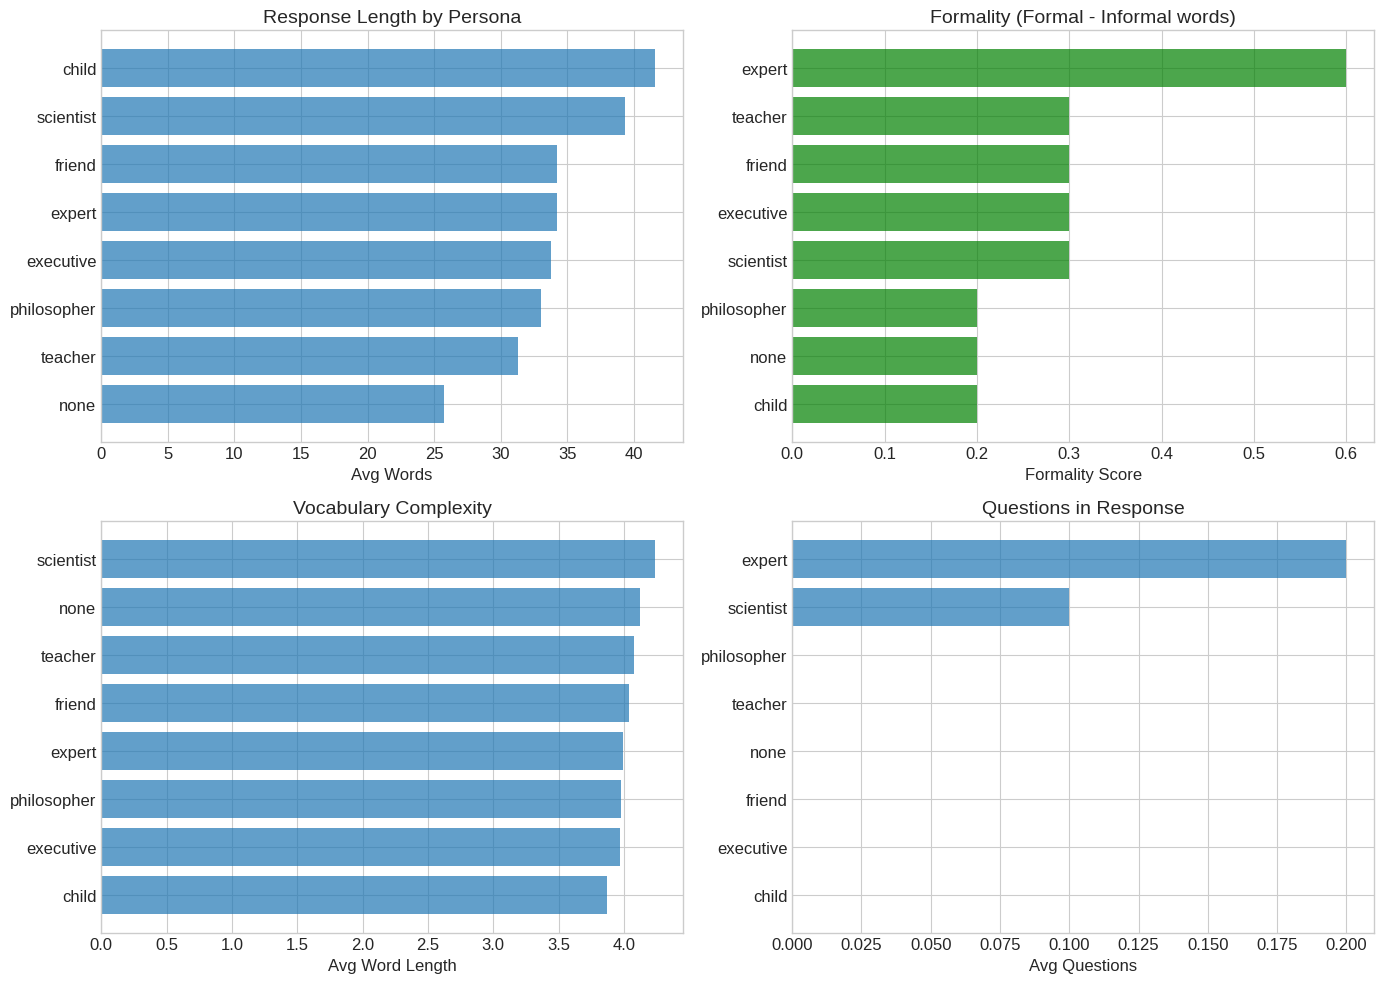

In [8]:
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Response length
ax = axes[0, 0]
data = persona_summary['length'].sort_values()
ax.barh(range(len(data)), data.values, alpha=0.7)
ax.set_yticks(range(len(data))); ax.set_yticklabels(data.index)
ax.set_xlabel('Avg Words'); ax.set_title('Response Length by Persona')

# Formality score (formal - informal)
ax = axes[0, 1]
formality = (persona_summary['formal_count'] - persona_summary['informal_count']).sort_values()
colors = ['green' if x > 0 else 'orange' for x in formality]
ax.barh(range(len(formality)), formality.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(formality))); ax.set_yticklabels(formality.index)
ax.set_xlabel('Formality Score'); ax.set_title('Formality (Formal - Informal words)')

# Avg word length (complexity proxy)
ax = axes[1, 0]
data = persona_summary['avg_word_length'].sort_values()
ax.barh(range(len(data)), data.values, alpha=0.7)
ax.set_yticks(range(len(data))); ax.set_yticklabels(data.index)
ax.set_xlabel('Avg Word Length'); ax.set_title('Vocabulary Complexity')

# Questions asked
ax = axes[1, 1]
data = persona_summary['question_count'].sort_values()
ax.barh(range(len(data)), data.values, alpha=0.7)
ax.set_yticks(range(len(data))); ax.set_yticklabels(data.index)
ax.set_xlabel('Avg Questions'); ax.set_title('Questions in Response')

plt.tight_layout()
plt.savefig('../results/exp5_persona_comparison.png', dpi=150)
plt.show()

## 5. Sample Responses

In [9]:
# Show same prompt under different personas
sample_test = TEST_SUBSET[0]
print(f"Prompt: {sample_test['prompt']}")
print("="*60)

for persona in ['none', 'teacher', 'scientist', 'friend', 'executive']:
    response = persona_df[(persona_df['test_id'] == sample_test['id']) & 
                          (persona_df['persona'] == persona)]['response'].values[0]
    print(f"\n[{persona.upper()}]")
    print(response[:200] + "..." if len(response) > 200 else response)

Prompt: What is the capital of France?

[NONE]
The capital of France is Paris.

[TEACHER]
The capital of France is Paris.

[SCIENTIST]
The capital of France is Paris.

[FRIEND]
The capital of France is Paris.

[EXECUTIVE]
The capital of France is Paris.


In [10]:
print("\n=== Key Findings ===")
print(f"Longest responses: {persona_summary['length'].idxmax()}")
print(f"Shortest responses: {persona_summary['length'].idxmin()}")
print(f"Most questions: {persona_summary['question_count'].idxmax()}")
print(f"Most complex vocabulary: {persona_summary['avg_word_length'].idxmax()}")


=== Key Findings ===
Longest responses: child
Shortest responses: none
Most questions: expert
Most complex vocabulary: scientist


In [11]:
import json
with open('../results/exp5_results.json', 'w') as f:
    json.dump({"persona_summary": persona_summary.to_dict()}, f, indent=2)
print("Saved.")

Saved.
